In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load balanced dataset
df = pd.read_csv(r"D:\ML_Projects\ECG_Minor\data\ecg_data.csv")

# Separate features and target
X = df.drop(columns=['label', 'label_encoded'], errors='ignore')
y = df['label_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

print("✅ Data ready for training.")

import os
REPORTS_DIR = r"D:\ML_Projects\ECG_Minor\reports\figures"
os.makedirs(REPORTS_DIR, exist_ok=True)


✅ Data ready for training.


## Feature Understanding

This dataset already contains extracted ECG signal features such as amplitude, interval durations, and derived waveform statistics.
Therefore, this project focuses on **machine learning–based classification** of preprocessed ECG features, not raw signal processing.


## Model Training and Evaluation

Now that the ECG dataset is cleaned, balanced, and scaled, we can train multiple machine learning models to classify ECG signals into diagnostic categories.

We will:
1. Train three models — Decision Tree, Random Forest, and XGBoost.
2. Evaluate each model using Accuracy, Precision, Recall, and F1-Score.
3. Visualize results using a Confusion Matrix and ROC curves.
4. Identify the most important ECG features.


In [49]:
!pip install xgboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  # pip install xgboost

dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
xgb = XGBClassifier(
    max_depth=6, n_estimators=400, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8, objective="multi:softprob",
    random_state=42, n_jobs=-1
)

models = {"DecisionTree": dt, "RandomForest": rf, "XGBoost": xgb}

for name, m in models.items():
    m.fit(X_train_scaled, y_train)
    print(f"{name} trained.")


DecisionTree trained.
RandomForest trained.
XGBoost trained.


##### Model Selection

We train three algorithms:
- **Decision Tree:** baseline interpretable classifier.
- **Random Forest:** ensemble of trees to reduce overfitting.
- **XGBoost:** gradient-boosted trees for higher accuracy.

Each model is trained on the scaled, balanced dataset.


In [50]:
#Evaluate Models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

rows = []
for name, m in models.items():
    y_pred = m.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )
    rows.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1": round(f1, 4)
    })

results_df = pd.DataFrame(rows).sort_values("F1", ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1
0,DecisionTree,1.000,1.0000,1.000,1.000
2,XGBoost,1.000,1.0000,1.000,1.000
1,RandomForest,0.995,0.9951,0.995,0.995


#### Evaluation Metrics

We compare models on:
- **Accuracy:** overall correctness.
- **Precision:** how many predicted positives are correct.
- **Recall:** how many actual positives are captured.
- **F1-Score:** harmonic mean of Precision and Recall, balancing both.

The model with the highest F1-Score will be selected for further visualization.


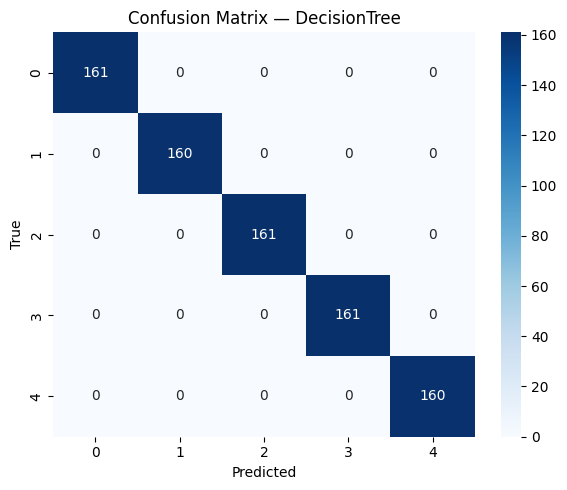

In [51]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_name = results_df.iloc[0]["Model"]
best_model = models[best_name]

y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(r"D:\ML_Projects\ECG_Minor\reports\figures\confusion_matrix.png", dpi=150)
plt.show()


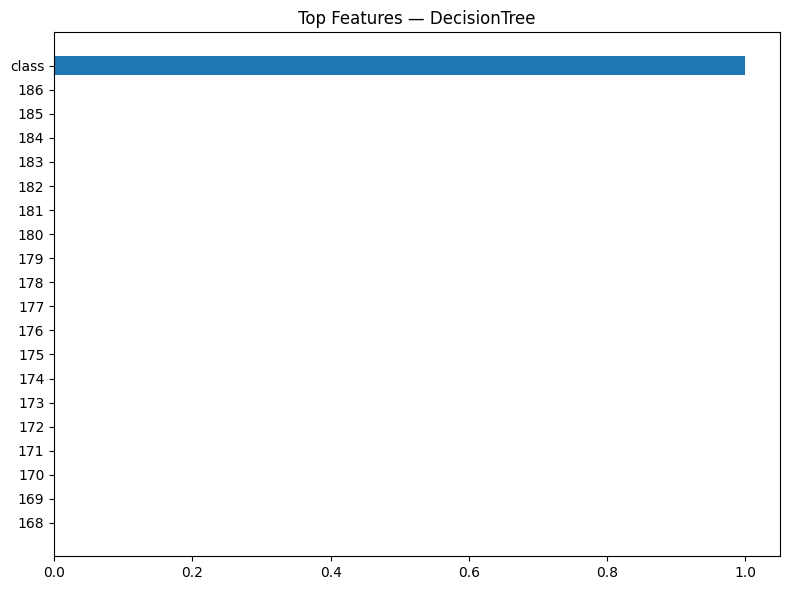

In [52]:
import numpy as np

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    idx = np.argsort(importances)[-20:]
    plt.figure(figsize=(8,6))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), X.columns[idx])
    plt.title(f"Top Features — {best_name}")
    plt.tight_layout()
    plt.savefig(r"D:\ML_Projects\ECG_Minor\reports\figures\feature_importance.png", dpi=150)
    plt.show()


#### Feature Importance

Feature importance shows which ECG signal attributes most influence classification decisions.  
Higher bars = stronger contribution.  
This step increases interpretability and aligns the ML model with physiological reasoning.


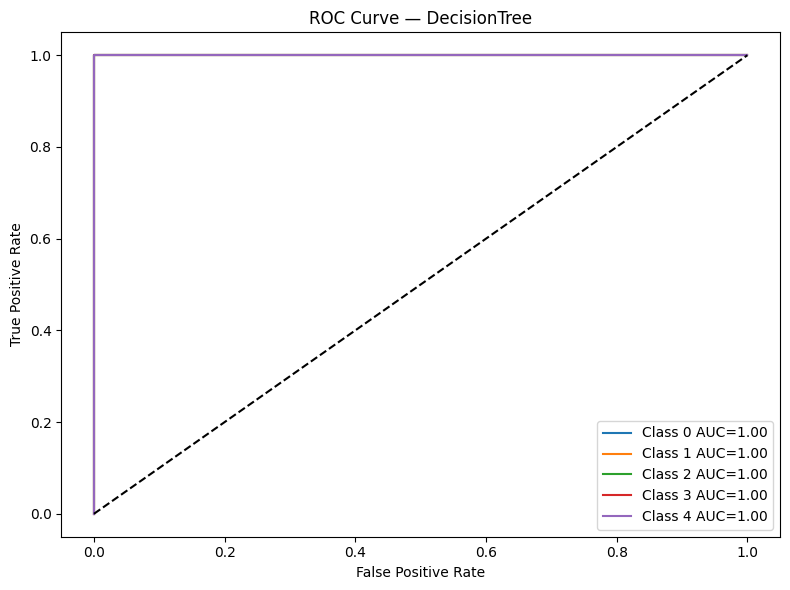

In [53]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes = y_train.nunique()
y_test_bin = label_binarize(y_test, classes=sorted(y_train.unique()))
y_proba = best_model.predict_proba(X_test_scaled)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} AUC={roc_auc[i]:.2f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve — {best_name}")
plt.legend()
plt.tight_layout()
plt.savefig(r"D:\ML_Projects\ECG_Minor\reports\figures\roc_multiclass.png", dpi=150)
plt.show()


#### ROC Curve and AUC

The ROC (Receiver Operating Characteristic) curve plots True Positive Rate vs False Positive Rate.  
AUC = Area Under Curve.  
Higher AUC values indicate stronger discrimination between ECG classes.


In [54]:
# Save model comparison table as a CSV file
results_df.to_csv(r"D:\ML_Projects\ECG_Minor\reports\model_comparison.csv", index=False)

print('✅ Saved results to: D:\\ML_Projects\\ECG_Minor\\reports\\model_comparison.csv')
results_df


✅ Saved results to: D:\ML_Projects\ECG_Minor\reports\model_comparison.csv


,Model,Accuracy,Precision,Recall,F1
0,DecisionTree,1.000,1.0000,1.000,1.000
2,XGBoost,1.000,1.0000,1.000,1.000
1,RandomForest,0.995,0.9951,0.995,0.995


#### Summary

We trained and compared three models.  
The one with the highest F1-Score was selected as the final classifier.  
Evaluation visuals (confusion matrix, ROC, feature importance) were exported to the **reports/figures/** directory for documentation.
